__Вводные данные:__

C целью определить лучший баннер в мобильном приложении, тестовой группе пользователей была предложена версия с другим цветовым решением с одинаковой возможность покупки платного функционала. A/B-тест был проведен в период с 08.05.2019 по 09.05.2019. 

__Задача:__

Необходимо оценить, какой из вариантов баннера является более предпочтительным для пользователей из региона US.

__Данные:__

__`Таблица Users`__:
- `UserID` – идентификационный номер пользователей;
- `Country` – регион продажи;
- `Group` – тип исследуемой группы.

__`Таблица Revenue`__:

- `UserID` – идентификационный номер пользователей;
- `Date` – дата просмотра пользователем баннера;
- `Revenue` – выручка от приобретения пользователем платного функционала, BYN
---

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from datetime import datetime
import seaborn as sns

In [ ]:
sns.set()

In [2]:
users = pd.read_excel('result.xlsx', sheet_name=1, usecols='A:C', nrows=40000, names=['user_id', 'country', 'group'], dtype={'user_id': np.int_}, keep_default_na=False)
revenue = pd.read_excel('result.xlsx', sheet_name=1, usecols='F:H', nrows=378525, names=['user_id', 'date', 'revenue'], dtype={'user_id': np.int_, 'date': datetime, 'revenue': np.float_})

In [164]:
# выборка данных согласно задаче и их объединение
users_US = users[users.country == 'US'] 
revenue_ab = revenue[(revenue.date == datetime(2019, 5, 8)) | (revenue.date == datetime(2019, 5, 9))]

ab_test = (pd.merge(users_US[['user_id', 'group']], revenue_ab[['user_id', 'revenue']], on='user_id')).groupby(['user_id', 'group'], as_index=False).sum()
control_group = ab_test.loc[ab_test.group == 'Control', 'revenue']
target_group = ab_test.loc[ab_test.group == 'Target', 'revenue']

In [165]:
print(f"ARPPU контрольной группы: {control_group.mean():.2f}")
print(f"ARPPU тестовой группы: {target_group.mean():.2f}")

ARPPU контрольной группы: 56.91
ARPPU тестовой группы: 61.99


Как видно из расчетов, __новый баннер__ оказался __предпочтительнее__. Подтвердим данную гипотезу статистически.

In [158]:
# узнаем распределение среднего значения выручки контрольной и тестовой групп c помощью bootstrap
sample_means_control = []
sample_means_target = []
for i in range(1000):
    sample_control = ab_test.loc[ab_test.group == 'Control', 'revenue'].sample(frac=0.9, replace=True)
    sample_target = ab_test.loc[ab_test.group == 'Target', 'revenue'].sample(frac=0.9, replace=True)
    sample_means_control.append(sample_control.mean())
    sample_means_target.append(sample_target.mean())

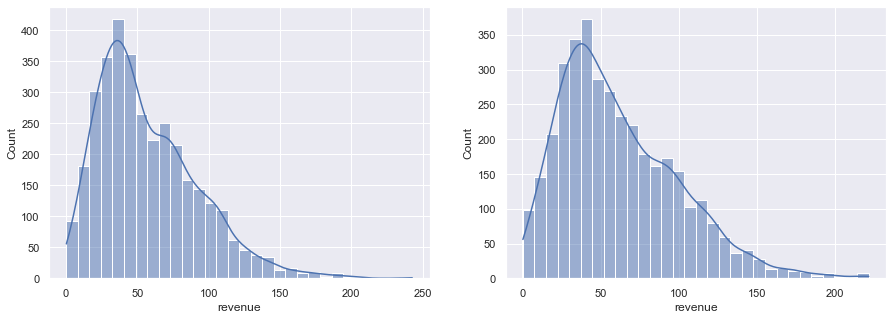

In [159]:
# распредление выручки
fig1, ax1 = plt.subplots(1, 2)
fig1.set_size_inches(15, 5)

sns.histplot(sample_control, bins=30, ax=ax1[0], kde=True)
sns.histplot(sample_target, bins=30, ax=ax1[1], kde=True);

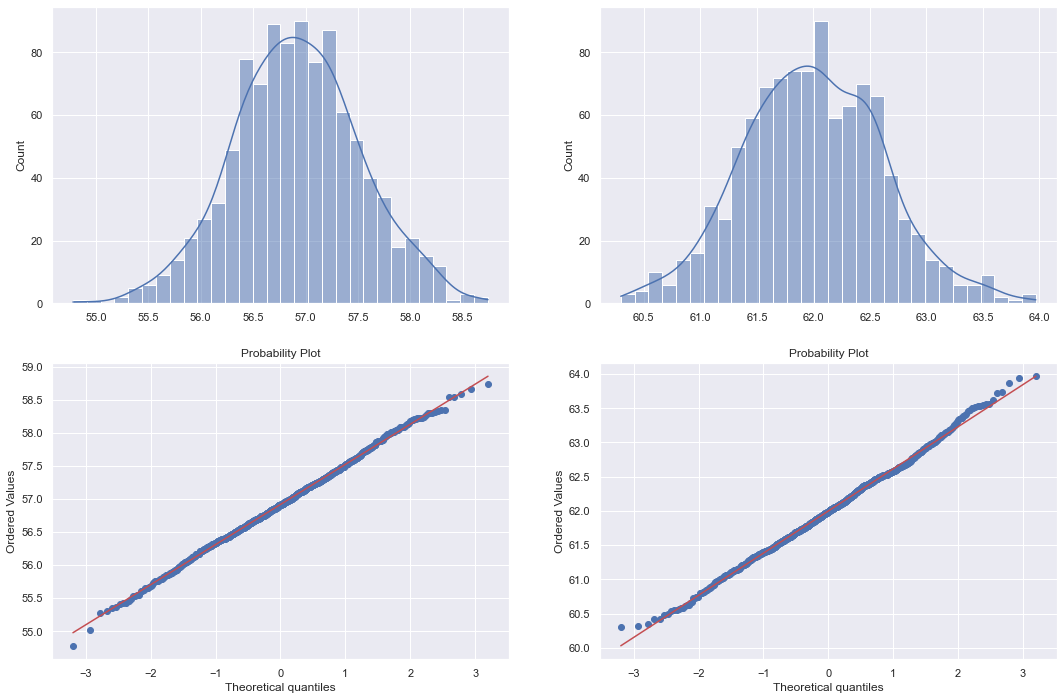

In [160]:
# распределение среднего значения выручки
fig2, ax2 = plt.subplots(2, 2)
fig2.set_size_inches(18, 12)

sns.histplot(sample_means_control, bins=30, ax=ax2[0, 0], kde=True)
sns.histplot(sample_means_target, bins=30, ax=ax2[0, 1], kde=True)
sts.probplot(sample_means_control, dist='norm', plot=ax2[1, 0])
sts.probplot(sample_means_target, dist='norm', plot=ax2[1, 1]);

In [161]:
# теперь проверим на нормальность с помощью теста Шапиро-Уилка
sp_cntrl = sts.shapiro(sample_means_control)
print(f'Тест на нормальность распределения ARPPU контрольной группы: W = {sp_cntrl[0]:.3f}, p-value = {sp_cntrl[1]:.3f}')

sp_trgt = sts.shapiro(sample_means_target)
print(f'Тест на нормальность распределения ARPPU тестовой группы: W = {sp_trgt[0]:.3f}, p-value = {sp_trgt[1]:.3f}')

Тест на нормальность распределения ARPPU контрольной группы: W = 0.999, p-value = 0.835
Тест на нормальность распределения ARPPU тестовой группы: W = 0.998, p-value = 0.201


In [187]:
tt = sts.ttest_ind(target_group, control_group, equal_var=False, alternative='greater')
print(f"Тест Стьюдента для средних 2-х независимых выборок c разным SD: t = {tt[0]:.3f}, p-value = {tt[1]:.3f}")

Тест Стьюдента для средних 2-х независимых выборок c разным SD: t = 6.112, p-value = 0.000


__p-value < 0.05__

__Результаты статистически значимы - новый баннер предпочтительнее.__